In [138]:
import pickle
import numpy as np 
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt 

In [196]:
PERSONAL_DATA_DIR_PROC = '/home/kitadam/ENR_Sven/moxie/data/processed/'
with open(PERSONAL_DATA_DIR_PROC + 'supervised_set_w_elm_timings.pickle', 'rb') as file:
    supervised_dict = pickle.load(file)
    
JET_PDB = pd.read_csv('../../../moxie/data/processed/jet-pedestal-database.csv')
PULSE_DF_SANDBOX = JET_PDB[(JET_PDB['FLAG:HRTSdatavalidated'] > 0) & (JET_PDB['shot'] > 80000) & (JET_PDB['Atomicnumberofseededimpurity'].isin([0, 7])) & (JET_PDB['FLAG:DEUTERIUM'] == 1.0) & (JET_PDB['FLAG:Kicks'] == 0.0) & (JET_PDB['FLAG:RMP'] == 0.0) & (JET_PDB['FLAG:pellets'] == 0.0)]
relevant_columns = ['shot', 'nepedheight10^19(m^-3)','Tepedheight(keV)', 'B(T)','Ip(MA)', 'q95',  'R(m)', 'a(m)','gasflowrateofmainspecies10^22(e/s)',  'P_TOT=PNBI+Pohm+PICRH-Pshi(MW)', 'P_ICRH(MW)', 'P_NBI(MW)','plasmavolume(m^3)', 'averagetriangularity', 'divertorconfiguration', 'FLAG:Seeding', 'FLAG:Kicks',
 'FLAG:RMP',
 'FLAG:pellets',]
mp_cols = supervised_dict['MP_ORDER']

In [197]:
def standardize(x, mu, var): 
    if mu is None and var is None: 
        mu = x.mean(0)
        var = x.std(0)
        x_normed = (x - mu ) / var
        return x_normed, mu, var
    else: 
        return (x - mu) / var
    
def standardize_mps(x, mu, var): 
    x_normed = np.copy(x)
    if mu is None and var is None: 
        mu = x[:, :-1].mean(0)
        var = x[:, :-1].std(0)
        x_normed[:, :-1] = (x[:, :-1] - mu ) / var
        return x_normed, mu, var
    else: 
        x_normed[:, :-1] = (x[:, :-1] - mu ) / var
        return x_normed
    
def de_standardize(x, mu, var): 
    return x*var + mu

In [198]:
data_train, nesep_train = supervised_dict['train']['mps_pulse'], supervised_dict['train']['neseps_pulse']
data_val, nesep_val = supervised_dict['val']['mps_pulse'], supervised_dict['val']['neseps_pulse']
data_test, nesep_test = supervised_dict['test']['mps_pulse'], supervised_dict['test']['neseps_pulse']


data_train_all, nesep_train_all = supervised_dict['train']['mps'], supervised_dict['train']['neseps']
data_val_all, nesep_val_all = supervised_dict['val']['mps'], supervised_dict['val']['neseps']
data_test_all, nesep_test_all = supervised_dict['test']['mps'], supervised_dict['test']['neseps']


# remove nans
data_train_without_nans = data_train[np.logical_not(np.logical_or(np.isnan(nesep_train), np.isnan(data_train[:, -1])))]
nesep_train_without_nans = nesep_train[np.logical_not(np.logical_or(np.isnan(nesep_train), np.isnan(data_train[:, -1])))]

data_train_all_without_nans = data_train_all[np.logical_not(np.logical_or(np.isnan(nesep_train_all), np.isnan(data_train_all[:, -1])))]
nesep_train_all_without_nans = nesep_train_all[np.logical_not(np.logical_or(np.isnan(nesep_train_all), np.isnan(data_train_all[:, -1])))]



data_val = data_val[np.logical_not(np.isnan(nesep_val))]
nesep_val = nesep_val[np.logical_not(np.isnan(nesep_val))]

data_val_all_without_nans = data_val_all[np.logical_not(np.logical_or(np.isnan(nesep_val_all), np.isnan(data_val_all[:, -1])))]
nesep_val_all_without_nans = nesep_val_all[np.logical_not(np.logical_or(np.isnan(nesep_val_all), np.isnan(data_val_all[:, -1])))]



data_test = data_test[np.logical_not(np.isnan(nesep_test))]
nesep_test = nesep_test[np.logical_not(np.isnan(nesep_test))]

data_test_all_without_nans = data_test_all[np.logical_not(np.logical_or(np.isnan(nesep_test_all), np.isnan(data_test_all[:, -1])))]
nesep_test_all_without_nans = nesep_test_all[np.logical_not(np.logical_or(np.isnan(nesep_test_all), np.isnan(data_test_all[:, -1])))]




# from moxie.data.utils_ import load_data, standardize, de_standardize, normalize_profiles, standardize_simple

data_train_norm, MP_mu, MP_var = standardize(data_train, None, None)
data_val_norm = standardize(data_val, MP_mu, MP_var )
data_test_norm = standardize(data_test, MP_mu, MP_var )

nesep_train_norm, NSEP_mu, NSEP_var = standardize(nesep_train, None, None)
nesep_val_norm = standardize(nesep_val, NSEP_mu, NSEP_var)
nesep_test_norm = standardize(nesep_test, NSEP_mu, NSEP_var)

data_train_all_norm,  MP_mu, MP_var = standardize_mps(data_train_all_without_nans, None, None)
data_val_all_norm = standardize_mps(data_val_all_without_nans,  MP_mu, MP_var)
data_test_all_norm = standardize_mps(data_test_all_without_nans,  MP_mu, MP_var)

data_train_all_norm[:, -1] = data_train_all_norm[:, -1]*100
data_val_all_norm[:, -1] = data_val_all_norm[:, -1]*100
data_test_all_norm[:, -1] = data_test_all_norm[:, -1]*100

nesep_train_all_norm, NSEP_mu, NSEP_var = standardize(nesep_train_all_without_nans, None, None)
nesep_val_all_norm = standardize(nesep_val_all_without_nans, NSEP_mu, NSEP_var)
nesep_test_all_norm = standardize(nesep_test_all_without_nans, NSEP_mu, NSEP_var)

/home/local/kitadam/ENR_Sven/general_ml/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [199]:
data_train_all_without_nans[:, :-1].shape, data_train_all_without_nans.shape, data_train_all_norm.shape
data_train_all_norm[:, -1].max()

99.99955078052191

In [200]:
# normalize 

dtrain = xgb.DMatrix(data_train_norm, nesep_train_norm)
dval = xgb.DMatrix(data_val_norm, nesep_val_norm)
dtest = xgb.DMatrix(data_test_norm, nesep_test_norm)
dtrain_all = xgb.DMatrix(data_train_all_norm, nesep_train_all_norm)
dval_all = xgb.DMatrix(data_val_all_norm, nesep_val_all_norm)
dtest_all = xgb.DMatrix(data_test_all_norm, nesep_test_all_norm)

evallist = [(dtest, 'eval'), (dtrain, 'train')]
evallist_all = [(dval_all, 'eval'), (dtrain_all, 'train')]


[0]	eval-rmse:1.04242	train-rmse:0.83439
[1]	eval-rmse:1.05672	train-rmse:0.63011
[2]	eval-rmse:1.08726	train-rmse:0.48018
[3]	eval-rmse:1.11974	train-rmse:0.36964
[4]	eval-rmse:1.14421	train-rmse:0.28719
[5]	eval-rmse:1.16671	train-rmse:0.22451
[6]	eval-rmse:1.18058	train-rmse:0.17667
[7]	eval-rmse:1.18829	train-rmse:0.13976
[8]	eval-rmse:1.19674	train-rmse:0.11133
[9]	eval-rmse:1.20531	train-rmse:0.08929
[10]	eval-rmse:1.20950	train-rmse:0.07196
[11]	eval-rmse:1.21363	train-rmse:0.05845
[12]	eval-rmse:1.21622	train-rmse:0.04754
[13]	eval-rmse:1.21866	train-rmse:0.03893
[14]	eval-rmse:1.22107	train-rmse:0.03212
[15]	eval-rmse:1.22253	train-rmse:0.02649
[16]	eval-rmse:1.22345	train-rmse:0.02190
[17]	eval-rmse:1.22392	train-rmse:0.01819
[18]	eval-rmse:1.22448	train-rmse:0.01511
[19]	eval-rmse:1.22505	train-rmse:0.01253
[20]	eval-rmse:1.22544	train-rmse:0.01050
[21]	eval-rmse:1.22565	train-rmse:0.00876
[22]	eval-rmse:1.22595	train-rmse:0.00734
[23]	eval-rmse:1.22622	train-rmse:0.00619
[2

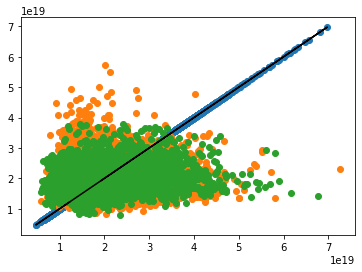

In [215]:
num_round = 100
param = {'max_d 
          epth': 30, 'eta': 0.3, 'gamma':0.00, 'objective': 'reg:squarederror'}
bst = xgb.train(param, dtrain_all, num_round, evallist_all)
# ypred_train = bst.predict(dtrain)
# ypred_val = bst.predict(dval)
# ypred_test = bst.predict(dtest)
ypred_train = de_standardize(bst.predict(dtrain_all), NSEP_mu, NSEP_var)
ypred_val = de_standardize(bst.predict(dval_all), NSEP_mu, NSEP_var)
ypred_test = de_standardize(bst.predict(dtest_all), NSEP_mu, NSEP_var)
plt.close('all')
plt.scatter(nesep_train_all_without_nans, ypred_train)
plt.plot(nesep_train_all_without_nans, nesep_train_all_without_nans, color='black')
plt.scatter(nesep_val_all_without_nans, ypred_val)
plt.scatter(nesep_test_all_without_nans, ypred_test)

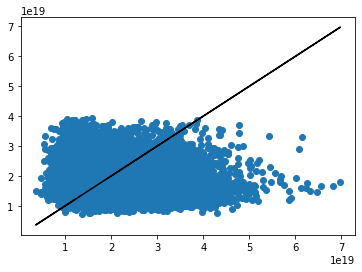

In [123]:
plt.close()


# ypred_all = bst.predict(dtrain_all) 
ypred_all = de_standardize(bst.predict(dtrain_all), NSEP_mu, NSEP_var)
plt.close('all')
plt.scatter(nesep_train_all, ypred_all)
plt.plot(nesep_train_all, nesep_train_all, color='black')


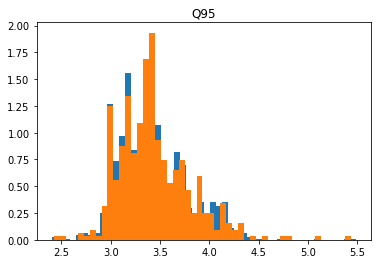

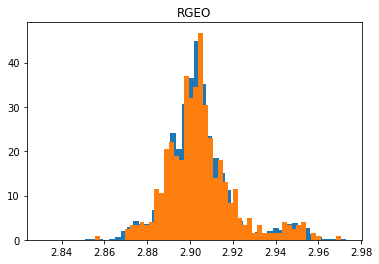

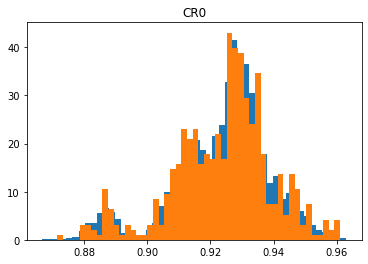

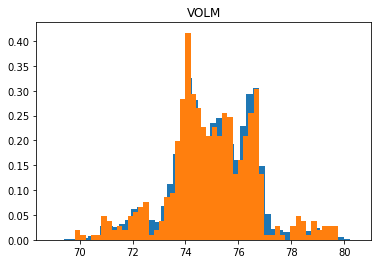

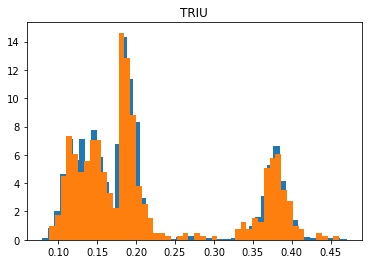

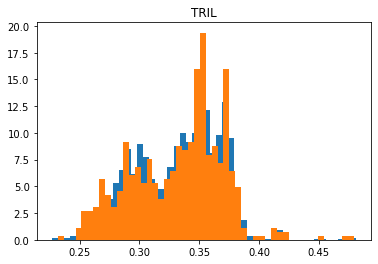

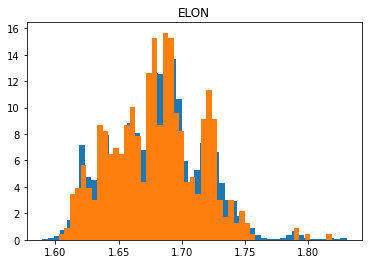

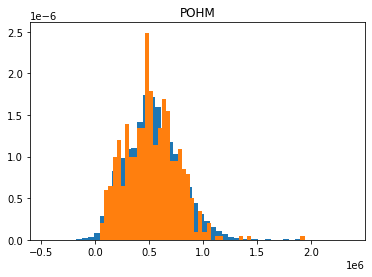

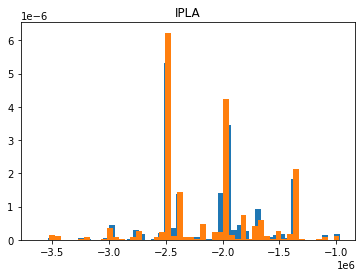

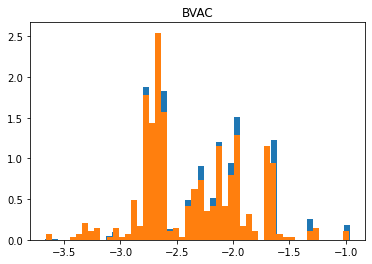

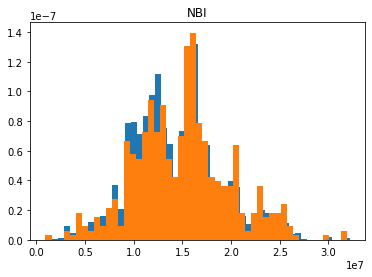

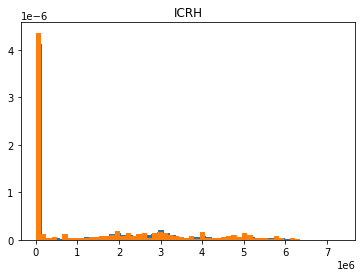

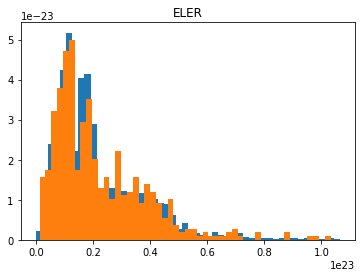

In [137]:
plt.close('all')
for k in range(len(data_train[0])): 
    plt.hist(data_train_all[:, k], density=True, bins=50)
    plt.hist(data_train[:, k], density=True, bins=50)
    plt.title(mp_cols[k])
    plt.show()

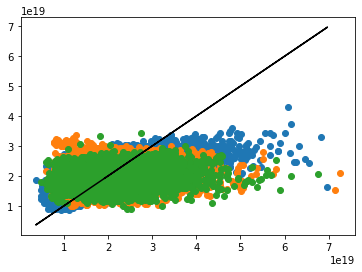